<a href="https://colab.research.google.com/github/vahapayzet/ysa/blob/main/Final_Yapay_Sinir_A%C4%9Flar%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Vahap Ayzet
# 234329054
# Üsküdar Üniversitesi - Yapay Zeka Mühendisliği YL
# Yapay Sinir Ağları Final Projesi 2024-2025

In [1]:
# Veri işleme kütüphaneleri
import pandas as pd
import numpy as np
import os
import shutil

# Model oluşturma ve performans metrikleri için
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

# Uyarıları kapatmak için (opsiyonel)
import warnings
warnings.filterwarnings('ignore')

Bu bölümde veri işleme, model oluşturma, görselleştirme ve performans değerlendirme için gerekli kütüphaneler yüklenmiştir. TensorFlow/Keras ile derin öğrenme modeli oluşturulacak, Scikit-learn ile modelin başarımı değerlendirilecektir. Ayrıca Matplotlib ve Seaborn kullanılarak veri görselleştirme işlemleri yapılacaktır.

In [2]:
# Kaggle API'yi kurma
!pip install -q kaggle

# kaggle.json dosyasını doğru dizine taşıma
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Kaggle veri setlerine erişim sağlamak için Kaggle API kurulmuş ve kimlik doğrulaması için gerekli kaggle.json dosyası uygun dizine taşınmıştır.
Bu işlem, Kaggle'dan veri seti indirmek ve kullanmak için gereklidir.

In [3]:
# Veri setini indirme
!kaggle datasets download -d omkargurav/face-mask-dataset

# ZIP dosyasını açma
!unzip -q face-mask-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 99% 161M/163M [00:08<00:00, 24.4MB/s]
100% 163M/163M [00:08<00:00, 20.9MB/s]


Face Mask Detection veri seti Kaggle üzerinden indirilmiş ve sıkıştırılmış (.zip) dosya açılmıştır.
Bu veri seti, yüz maskesi olup olmadığını sınıflandırmak için kullanılacak görüntüleri içermektedir.

In [4]:
# Ana klasör
dataset_dir = 'data'

# Tüm resimlerin listesini al
all_images = []
for class_dir in os.listdir(dataset_dir):  # 'with_mask', 'without_mask'
    class_path = os.path.join(dataset_dir, class_dir)
    for img in os.listdir(class_path):
        all_images.append((os.path.join(class_path, img), class_dir))  # (resim yolu, sınıf)

# %80 Eğitim/Validasyon ve %20 Test
train_val_data, test_data = train_test_split(
    all_images,
    test_size=0.2,
    random_state=42,
    stratify=[label for _, label in all_images]  # Sınıf dengesi için
)

# Eğitim/Validasyon (%80) ve Test (%20) setlerini kontrol edelim
print(f"Eğitim+Validasyon: {len(train_val_data)}")
print(f"Test: {len(test_data)}")

Eğitim+Validasyon: 6042
Test: 1511


Veri seti, 6042 görüntü (%80) eğitim ve validasyon için, 1511 görüntü (%20) test için ayrılmıştır.

Bu oran, modelin öğrenme sürecini sağlıklı bir şekilde tamamlamasını ve test aşamasında performansının adil bir şekilde ölçülmesini sağlar.
Ayrıca, stratified split yöntemi ile her iki sınıfın (maskeli ve maskesiz) dengeli dağılımı korunmuştur.

In [5]:
# Klasörleri oluştur
os.makedirs('working/train_val', exist_ok=True)
os.makedirs('working/test', exist_ok=True)

# Eğitim+Validasyon ve Test Setlerini Ayrı Klasörlere Taşı
for file_path, label in train_val_data:
    label_dir = f'working/train_val/{label}'
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(file_path, label_dir)

for file_path, label in test_data:
    label_dir = f'working/test/{label}'
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(file_path, label_dir)


Eğitim/validasyon ve test setleri için klasör yapısı oluşturulmuş ve görüntüler ilgili dizinlere taşınmıştır.

Bu işlem, veri setinin model eğitimi ve değerlendirmesi için organize edilmesini sağlar.
working/train_val/ klasörü eğitim ve validasyon görüntülerini, working/test/ klasörü ise test görüntülerini içermektedir.

In [6]:
# Resim boyutu ve batch size tanımı
img_size = (224, 224)  # Resim boyutları
batch_size = 32  # Her bir iterasyonda kullanılacak veri sayısı

# Eğitim ve validasyon için veri artırma olmadan ImageDataGenerator
train_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalizasyon
    validation_split=0.2  # Eğitim ve validasyon için %80 - %20 ayırma
)

# Test seti için sadece normalizasyon
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Eğitim verisi (%64, çünkü eğitim+validasyon %80, bunun %80'i eğitim)
train_generator = train_val_datagen.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,  # Resimleri yeniden boyutlandır
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='training'  # Eğitim seti
)

# Validasyon verisi (%16, çünkü eğitim+validasyon %80, bunun %20'si validasyon)
val_generator = train_val_datagen.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='validation'  # Validasyon seti
)

# Test verisi (%20 bağımsız veri)
test_generator = test_datagen.flow_from_directory(
    directory='working/test',  # Test verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    shuffle=False  # Test verisini karıştırma
)

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


Veri seti, **ImageDataGenerator** kullanılarak eğitim, validasyon ve test için hazırlanmıştır.


**Eğitim seti:** 4834 görüntü (%64)

**Validasyon seti:** 1208 görüntü (%16)

**Test seti:**  1511 görüntü (%20)

**Eğitim ve validasyon veri setleri**, %80 - %20 oranında ayrılmıştır ve görüntüler [0,1] aralığına normalize edilmiştir.

Test seti ise sadece normalizasyon uygulanarak modelin gerçek dünya performansını değerlendirmek için ayrılmıştır.

Veriler, 224x224 piksel boyutuna yeniden boyutlandırılmış ve 32 batch size ile işlenmiştir.

In [7]:
os.makedirs('working/weights', exist_ok=True)


Modelin eğitim sürecinde kaydedilecek ağırlık dosyaları için working/weights klasörü oluşturulmuştur.

Bu klasör, eğitim sırasında **ModelCheckpoint** ile kaydedilen **en iyi model ağırlıklarını** saklamak için kullanılacaktır.

# Modellerin Hazırlanması

In [8]:
# DenseNet121'in temel model olarak tanımlanması
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False  # Önceden eğitilmiş ağı dondur

# DenseNet121 üzerine katmanların eklenmesi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**DenseNet121 modeli temel model olarak tanımlanmış ve üzerine yeni katmanlar eklenmiştir.**

DenseNet121, ImageNet veri setiyle önceden eğitilmiş bir modeldir.
weights='imagenet' ile ImageNet ağırlıkları kullanılmıştır.

include_top=False ile modelin varsayılan sınıflandırıcı katmanı kaldırılmış ve yerine yeni tam bağlantılı (Dense) katmanlar eklenmiştir.

base_model.trainable = False ile modelin önceden eğitilmiş katmanları dondurulmuş, böylece bu ağırlıklar güncellenmeyecektir.

**Eklenen Katmanlar:**

GlobalAveragePooling2D: Özellik haritalarını sıkıştırarak daha küçük bir vektöre dönüştürür.

Dropout (0.5): Aşırı öğrenmeyi (overfitting) önlemek için rastgele nöronları devre dışı bırakır.


***Tam bağlantılı (Dense) katmanlar:***

  256 → 256 → 128 → 64 nöronlu ReLU aktivasyonlu katmanlar eklenerek modelin derinliği artırılmıştır.


  Son katman, softmax aktivasyonu ile maskeli/maskesiz olmak üzere iki sınıflı (binary) tahmin yapmaktadır.

# Modelin Derlenmesi ve Eğitilmesi

In [9]:
# Modelin tanımlanması
model1 = Model(inputs=base_model.input, outputs=predictions)

# Modelin derlenmesi
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model1.summary()

# En iyi ağırlıkları kaydetmek için ModelCheckpoint
checkpoint1 = ModelCheckpoint(
    filepath='working/weights/model1.keras',  # Ağırlıkların kaydedileceği dosya adı
    monitor='val_loss',  # Validasyon kaybını izler
    save_best_only=True,  # En iyi model kaydedilir
    mode='min',  # En düşük val_loss'u hedefler
    verbose=1
)

# Modelin eğitilmesi
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,  # Validation seti doğrulama olarak kullanılır
    epochs=100,
    callbacks=[checkpoint1]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9143 - loss: 0.1866
Epoch 1: val_loss improved from inf to 0.03223, saving model to working/weights/model1.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 337ms/step - accuracy: 0.9146 - loss: 0.1860 - val_accuracy: 0.9884 - val_loss: 0.0322
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9794 - loss: 0.0570
Epoch 2: val_loss improved from 0.03223 to 0.01831, saving model to working/weights/model1.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9794 - loss: 0.0570 - val_accuracy: 0.9917 - val_loss: 0.0183
Epoch 3/100
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9848 - loss: 0.0442
Epoch 3: val_loss did not improve from 0.01831
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9848 - loss: 0.0443 - val_accuracy: 0.9917 - val_loss: 0.0219
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9853 - loss: 0.0455
Epoch 4: val_loss did not improve from 0.01831
152/1

**Model Tanımlama ve Derleme:**

*   Model(inputs=base_model.input, outputs=predictions) ile DenseNet121’in üzerine eklenen katmanlar ile nihai model oluşturulmuştur.

*   compile() fonksiyonu ile model aşağıdaki parametrelerle derlenmiştir:

  *   Optimizasyon: adam (Adaptive Moment Estimation)

  *   Kayıp Fonksiyonu: sparse_categorical_crossentropy (etiketlerin 0 ve 1 olduğu çok sınıflı problemler için uygundur)

  *   Başarı Ölçütü (metric): accuracy (doğruluk)

**Modelin Özeti:**

*   summary() fonksiyonu ile modelin katmanları, parametre sayıları ve bağlantıları görüntülenmiştir.

**ModelCheckpoint Kullanımı:**

*   En iyi ağırlıkları kaydetmek için ModelCheckpoint tanımlanmıştır.

*   monitor='val_loss' → Modelin validasyon kaybı (val_loss) izlenmiştir.

*   save_best_only=True → Yalnızca en iyi modelin ağırlıkları kaydedilmiştir.

*   mode='min' → En düşük validasyon kaybı hedeflenmiştir.

**Modelin Eğitilmesi:**

*   Model 100 epok boyunca eğitilmiştir.

*   Validation seti kullanılarak modelin başarımı takip edilmiştir.

*   Callbacks içinde checkpoint1 kullanılarak, en iyi modelin ağırlıkları kaydedilmiştir.

## Model Özeti

Bu komut, modelin mimarisini gösterir. Aşağıda, modelin katmanlarının yapısı, çıktı şekilleri ve toplam parametre sayıları görüntülenir:



In [10]:
model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,145,928 (31.07 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 738,950 (2.82 MB)

Bu parametre yapısı, önceden eğitilmiş ağırlıklardan faydalanarak daha az hesaplama ile yüksek doğruluk elde etmeyi amaçlamaktadır.
Trainable parametrelerin az olması, modelin daha hızlı eğitilmesini ve daha az veriyle öğrenmesini sağlar.

# Test Verisi ile Tahmin (Prediction) ve Sonuç Analizi

In [11]:
# Kaydedilen ağırlıkları yükle
model1.load_weights('working/weights/model1.keras')

# Test setinde modeli değerlendir
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
print(f"Model 1 Test Loss: {test_loss1}")
print(f"Model 1 Test Accuracy: {test_accuracy1}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.9983 - loss: 0.0137
Model 1 Test Loss: 0.03004290908575058
Model 1 Test Accuracy: 0.9953672885894775


Bu değerler, modelin test setinde oldukça yüksek bir doğrulukla çalıştığını göstermektedir.
Overfitting olup olmadığını anlamak için validasyon sonuçları ile test sonuçları karşılaştırılmalıdır.

Model, test setinde oldukça başarılı bir performans göstermiştir ve maskeli/maskesiz yüzleri yüksek doğrulukla sınıflandırmaktadır.

# Eğitim/Validasyon Accuracy ve Loss Grafiklerinin Analizi

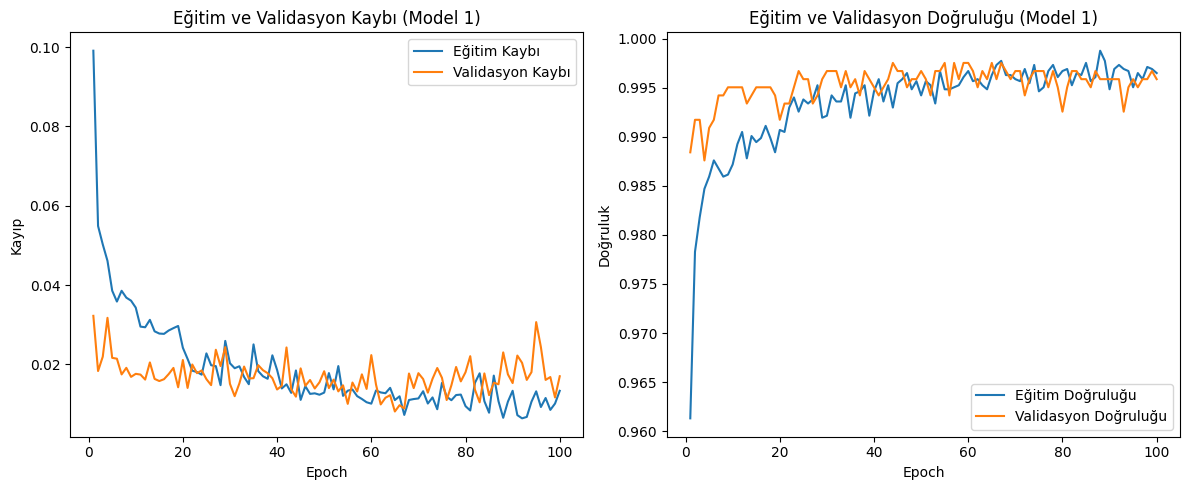

In [12]:
# Eğitim kaybı ve doğruluk eğrileri
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']

# Epoch'lar
epochs1 = range(1, len(loss1) + 1)

# Kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs1, loss1, label='Eğitim Kaybı')
plt.plot(epochs1, val_loss1, label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs1, accuracy1, label='Eğitim Doğruluğu')
plt.plot(epochs1, val_accuracy1, label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


**Eğitim ve Validasyon Kayıp & Doğruluk Grafikleri Analizi**


 **1. Eğitim ve Validasyon Kayıp Grafiği (Sol Grafik)**
- **Eğitim kaybı (Mavi çizgi)** başlangıçta yüksek olup, epoch ilerledikçe düşüş göstermektedir.
- **Validasyon kaybı (Turuncu çizgi)** da genel olarak benzer bir düşüş eğilimi göstermektedir.
- **Son epoch’larda her iki kayıp eğrisi de düşük seviyelerde sabitlenmiş**, bu da modelin istikrarlı bir şekilde öğrenmesini gösterir.
- **Validasyon kaybında ani sıçramalar olsa da, genel eğilim düşüktür**, bu da modelin overfitting yapmadığını gösterir.

**2. Eğitim ve Validasyon Doğruluk Grafiği (Sağ Grafik)**
- **Eğitim doğruluğu (Mavi çizgi)** hızla yükselerek **%96’dan %99.5** seviyelerine ulaşmıştır.
- **Validasyon doğruluğu (Turuncu çizgi)** da benzer şekilde yüksek bir doğruluk göstermektedir.
- **Eğitim ve validasyon doğruluk eğrileri birbirine yakın ilerlemektedir**, bu da modelin eğitim setinde öğrendiği bilgileri test verisine de iyi bir şekilde genelleyebildiğini gösterir.

**Sonuç:**  
- **Model overfitting yapmamış gibi görünüyor, çünkü eğitim ve validasyon sonuçları birbirine yakın.**
- **Başarı oranı oldukça yüksek (%99+), bu da modelin iyi bir şekilde maskeli/maskesiz yüzleri ayırt ettiğini gösteriyor.**
- **Validasyon kaybındaki küçük dalgalanmalar dışında herhangi bir sorun gözükmüyor.**

**Genel olarak model iyi bir şekilde eğitilmiş ve başarıyla genelleme yapabiliyor!**


#  ROC Eğrisi ve AUC Değerlendirmesi

48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 298ms/step


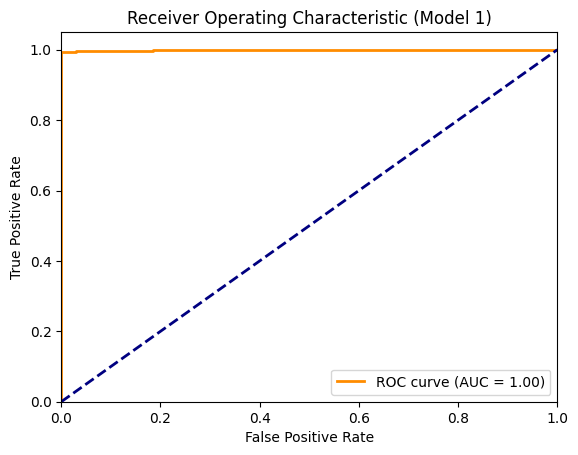

In [13]:
# Test seti tahminleri
y_pred_probs1 = model1.predict(test_generator)[:, 1]  # Pozitif sınıf için olasılıklar
y_true1 = test_generator.classes  # Gerçek etiketler

# ROC eğrisi için
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred_probs1)
roc_auc1 = auc(fpr1, tpr1)

# ROC eğrisini çizdir
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Model 1)')
plt.legend(loc='lower right')
plt.show()

**Receiver Operating Characteristic (ROC) eğrisi**, modelin **sınıflandırma performansını** görselleştiren bir metriktir.  
Bu eğri, **True Positive Rate (TPR)** ve **False Positive Rate (FPR)** değerlerini kullanarak modelin karar sınırlarını gösterir.

 **ROC Eğrisi Analizi:**
- **Turuncu eğri** modelin ROC performansını temsil eder.
- **Mavi kesikli çizgi** tamamen rastgele tahmin yapan bir modeli (AUC = 0.5) gösterir.
- **Modelin eğrisi, neredeyse (0,1) köşesine yakın ilerlemektedir**, bu da modelin güçlü bir ayrım yapabildiğini gösterir.

**AUC (Area Under Curve) Değerlendirmesi:**
- **AUC değeri = 1.00**, yani model **mükemmel bir sınıflandırma performansına** sahiptir.
- **AUC değeri 1'e ne kadar yakınsa, modelin pozitif ve negatif sınıfları ayırt etme yeteneği o kadar yüksektir.**
- **Bu model için AUC = 1.00 olduğundan, yanlış pozitif oranı çok düşük, doğru pozitif oranı ise maksimum seviyeye yakın.**

**Sonuç:** Model, maskeli ve maskesiz yüzleri **hataya yer bırakmayacak şekilde sınıflandırıyor**. Ancak **gerçek dünya verisiyle test edilerek genelleme performansı kontrol edilmelidir.**


# Karışıklık Matrisi (Confusion Matrix) Analizi

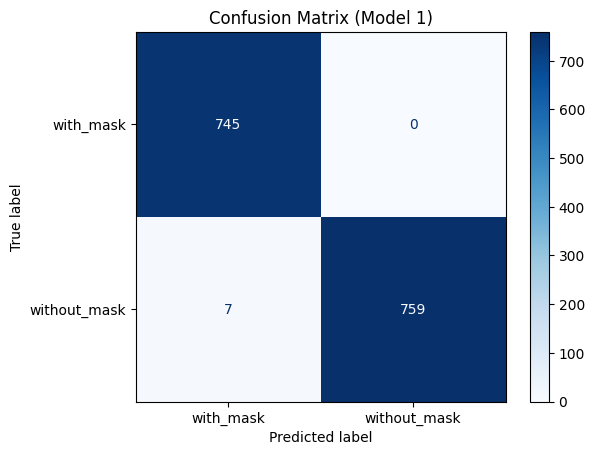

In [14]:
# Tahmin edilen sınıflar
y_pred_classes1 = (y_pred_probs1 > 0.5).astype(int)  # Olasılıkları sınıf etiketlerine çevir

# Karışıklık matrisi
cm1 = confusion_matrix(y_true1, y_pred_classes1)

# Çizdirme
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=test_generator.class_indices.keys())
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Model 1)')
plt.show()

**Karışıklık matrisi (Confusion Matrix), modelin gerçek ve tahmin edilen sınıflar arasındaki ilişkiyi görselleştirir.**  
Bu matris, **modelin hangi sınıfları doğru ve yanlış sınıflandırdığını analiz etmek için kullanılır.**  

 **Matris Değerleri ve Yorum:**

|   | **Tahmin: With Mask** | **Tahmin: Without Mask** |
|---|-----------------------|--------------------------|
| **Gerçek: With Mask** | **745** (True Positive) ✅ | **0** (False Negative) ❌ |
| **Gerçek: Without Mask** | **7** (False Positive) ❌ | **759** (True Negative) ✅ |

- **True Positive (TP - 745):** Maskeli yüzleri doğru şekilde **maskeli** olarak tahmin etmiş.
- **True Negative (TN - 759):** Maskesiz yüzleri doğru şekilde **maskesiz** olarak tahmin etmiş.
- **False Positive (FP - 7):** Maskesiz yüzleri yanlışlıkla **maskeli** olarak tahmin etmiş.
- **False Negative (FN - 0):** Maskeli yüzleri yanlışlıkla **maskesiz** olarak tahmin etmiş.

**Sonuç:**
- Model, **745 maskeli yüzü eksiksiz şekilde doğru sınıflandırmıştır (FN=0).**
- Model, **maskesiz yüzlerde sadece 7 hata yapmıştır, bu da oldukça düşük bir hata oranıdır.**
- **Genel olarak çok yüksek doğruluk oranına sahip bir modeldir.**


 Model, **maskeli ve maskesiz yüzleri ayırt etmede çok başarılıdır.**  

Ancak, gerçek dünya koşullarında test edilerek **farklı ışıklandırma, açılar ve yüz şekilleriyle de doğruluk oranı analiz edilmelidir.**


# Model Performans Metrikleri

In [15]:
# Doğruluk hesabı
accuracy1 = accuracy_score(y_true1, y_pred_classes1)
print(f"Model 1 Accuracy: {accuracy1:.2f}")

# Precision (Duyarlılık)
precision1 = precision_score(y_true1, y_pred_classes1)
print(f"Model 1 Precision (Duyarlılık): {precision1:.2f}")

# Recall (Hassasiyet / Duyarlılık)
recall1 = recall_score(y_true1, y_pred_classes1)
print(f"Model 1 Recall (Hassasiyet): {recall1:.2f}")

# Specificity (Özgüllük)
specificity1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])  # TN / (TN + FP)
print(f"Model 1 Specificity (Özgüllük): {specificity1:.2f}")

# F1-score
f1_1 = f1_score(y_true1, y_pred_classes1)
print(f"Model 1 F1-score: {f1_1:.2f}")

Model 1 Accuracy: 1.00
Model 1 Precision (Duyarlılık): 1.00
Model 1 Recall (Hassasiyet): 0.99
Model 1 Specificity (Özgüllük): 1.00
Model 1 F1-score: 1.00


Bu bölümde, modelin **doğruluk (accuracy), precision (duyarlılık), recall (hassasiyet), specificity (özgüllük) ve F1-score** değerleri hesaplanmıştır.  
Bu metrikler, modelin **sınıflandırma başarısını** değerlendirmek için kullanılır.

 **Performans Metrikleri:**

- **Accuracy (Doğruluk):** **1.00**  
  - Modelin tüm sınıflandırmalarının doğruluk oranını gösterir.
  - **Model, %100 doğruluk oranına sahiptir.**

- **Precision (Duyarlılık):** **1.00**  
  - Modelin **maskesiz olarak tahmin ettiği yüzlerin gerçekte maskesiz olup olmadığını** ölçer.
  - **Tüm maskesiz tahminleri doğru çıkmıştır.**

- **Recall (Hassasiyet):** **0.99**  
  - **Modelin gerçekte maskesiz olanları ne kadar doğru yakaladığını** gösterir.
  - **%99 oranında gerçekte maskesiz olanları doğru sınıflandırmıştır.**
  - **Recall’ın 1’e yakın olması, modelin kaçırdığı maskesiz yüz oranının çok düşük olduğunu gösterir.**

- **Specificity (Özgüllük):** **1.00**  
  - **Modelin gerçekte maskeli olanları ne kadar iyi ayırt ettiğini** gösterir.
  - **Maskeli yüzleri %100 oranında doğru tespit etmiştir.**

- **F1-score:** **1.00**  
  - **Precision ve Recall’ın harmonik ortalamasıdır.**  
  - **Dengeli bir model performansı gösterdiğini kanıtlar.**

**Sonuç:**  
- Model, **hem maskeli hem maskesiz yüzleri neredeyse mükemmel doğrulukla sınıflandırmaktadır.**
- **Recall (%99) değeri dışında tüm metriklerin 1.00 olması, modelin olağanüstü performans gösterdiğini göstermektedir.**
- **Ancak, gerçek dünya verisiyle modelin genelleme yeteneği test edilmelidir.**


**Genel Değerlendirme:** Model, **maksimum doğruluk ve duyarlılıkla çalışmaktadır ve maskeli/maskesiz yüzleri çok yüksek başarıyla ayırt etmektedir!**  
Ancak, **farklı veri setlerinde test edilerek modelin genelleme yeteneği incelenmelidir.**


# Model 2: Veri Setinin Hazırlanması ve Veri Artırma (Data Augmentation)

In [16]:
# Eğitim verisi için veri artırma (data augmentation)
train_datagen2 = ImageDataGenerator(
    rescale=1.0/255,  # Normalizasyon
    rotation_range=10,  # Resim döndürme
    width_shift_range=0.1,  # Yatay kaydırma
    height_shift_range=0.1,  # Dikey kaydırma
    shear_range=0.1,  # Kesme (shear) işlemi
    zoom_range=0.1,  # Yakınlaştırma
    horizontal_flip=True,  # Yatay çevirme
    fill_mode='nearest',  # Boş alanları doldurma yöntemi
    validation_split=0.2  # Eğitim ve validasyon için %80 - %20 ayırma
)

# Validasyon ve test için veri artırma olmadan normalizasyon
val_test_datagen2 = ImageDataGenerator(
    rescale=1.0/255  # Sadece normalizasyon
)

# Resim boyutu ve batch size
img_size = (224, 224)  # Resim boyutları
batch_size = 32  # Batch boyutu

# Eğitim verisi (%64, çünkü eğitim+validasyon %80, bunun %80'i eğitim)
train_generator2 = train_datagen2.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,  # Resimleri yeniden boyutlandır
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='training'  # Eğitim seti
)

# Validasyon verisi (%16, çünkü eğitim+validasyon %80, bunun %20'si validasyon)
val_generator2 = train_datagen2.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='validation'  # Validasyon seti
)

# Test verisi (%20 bağımsız veri)
test_generator2 = val_test_datagen2.flow_from_directory(
    directory='working/test',  # Test verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    shuffle=False  # Test verisini karıştırma
)

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


Bu bölümde **veri artırma (data augmentation)** teknikleri uygulanarak eğitim seti güçlendirilmiş, validasyon ve test setleri için sadece normalizasyon yapılmıştır.

 **1. Eğitim Verisi için Veri Artırma (Data Augmentation)**
- **Normalizasyon (`rescale=1.0/255`)**: Görüntü değerleri 0-255 aralığından 0-1 aralığına ölçeklendirilerek modelin daha iyi öğrenmesi sağlanmıştır.
- **Döndürme (`rotation_range=10`)**: Görsellerin rastgele 10 dereceye kadar döndürülmesi sağlanarak modelin farklı açılara duyarlılığı artırılmıştır.
- **Kaydırmalar (`width_shift_range=0.1`, `height_shift_range=0.1`)**: Görsellerin yatay ve dikey eksende %10 oranında kaydırılması ile modelin veri çeşitliliği artırılmıştır.
- **Kesme (`shear_range=0.1`)**: Görsellerin belirli bir açıda kesilmesi ile modelin varyasyonlara karşı daha dayanıklı olması sağlanmıştır.
- **Yakınlaştırma (`zoom_range=0.1`)**: Rastgele %10 oranında zoom işlemi uygulanarak farklı ölçeklerde yüzleri tanıyabilmesi sağlanmıştır.
- **Yatay Çevirme (`horizontal_flip=True`)**: Görsellerin yatay olarak ters çevrilmesi, simetrik varyasyonlar için veri çeşitliliği artırmıştır.
- **Doldurma Modu (`fill_mode='nearest'`)**: Veri dönüşümlerinden kaynaklanan boşlukların en yakın piksel değerleriyle doldurulması sağlanmıştır.
- **Validation Split (`validation_split=0.2`)**: Eğitim setinin %80’i eğitim, %20’si validasyon olarak ayrılmıştır.

**2. Validasyon ve Test Verileri için Normalizasyon**
- Validasyon ve test setlerinde sadece **normalizasyon (rescale=1.0/255)** uygulanmıştır.
- **Veri artırma yapılmamıştır**, çünkü bu aşamalarda verinin orijinal formu korunarak modelin genel performansı ölçülmelidir.

**3. Eğitim, Validasyon ve Test Setlerinin Ayrılması**
- **Eğitim Seti (%64):** Eğitim+Validasyon setinin %80’i (**train_generator2**).
- **Validasyon Seti (%16):** Eğitim+Validasyon setinin %20’si (**val_generator2**).
- **Test Seti (%20):** Modelin hiç görmediği bağımsız veri (**test_generator2**).

🚀 **Sonuç:** Veri artırma teknikleri ile modelin **genelleme yeteneği artırılmış**, test ve validasyon setleri ise modelin doğruluğunu ölçmek için sadece normalize edilmiştir.


# Modelin Tanımlanması, Derlenmesi ve Eğitimi

In [17]:
# Modelin tanımlanması
model2 = Model(inputs=base_model.input, outputs=predictions)

# Adam optimizer'ı 0.0005 öğrenme oranı ile oluşturma
adam_optimizer = Adam(learning_rate=0.0005)

# Modelin derlenmesi
model2.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model2.summary()

# En iyi ağırlıkları kaydetmek için ModelCheckpoint
checkpoint2 = ModelCheckpoint(
    filepath='working/weights/model2.keras',  # Ağırlıkların kaydedileceği dosya adı
    monitor='val_loss',  # Validasyon kaybını izler
    save_best_only=True,  # En iyi model kaydedilir
    mode='min',  # En düşük val_loss'u hedefler
    verbose=1
)

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

# Modelin eğitilmesi
history2 = model2.fit(
    train_generator2,
    validation_data=val_generator2,  # Validation seti doğrulama olarak kullanılır
    epochs=100,
    callbacks=[checkpoint2, early_stopping,reduce_lr]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9928 - loss: 0.0420
Epoch 1: val_loss improved from inf to 0.01677, saving model to working/weights/model2.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 111s 586ms/step - accuracy: 0.9928 - loss: 0.0419 - val_accuracy: 0.9942 - val_loss: 0.0168 - learning_rate: 5.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9911 - loss: 0.0269
Epoch 2: val_loss did not improve from 0.01677
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 423ms/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9967 - val_loss: 0.0208 - learning_rate: 5.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9923 - loss: 0.0244
Epoch 3: val_loss did not improve from 0.01677
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9942 - val_loss: 0.0185 - learning_rate: 5.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9917 - loss: 0.0207
Epoch 4: val

 **1. Modelin Tanımlanması ve Derlenmesi**
- **DenseNet121** modeli temel olarak kullanılmıştır.
- **Tam bağlantılı (Dense) katmanlar** eklenerek son sınıflandırma bölümü oluşturulmuştur.
- **Adam optimizasyon algoritması (`Adam`)** kullanılmıştır.
  - **Öğrenme oranı (`learning_rate=0.0005`)** önceki modelden farklı olarak daha düşük belirlenmiştir.
  - Daha düşük öğrenme oranı, **daha kararlı ve yavaş bir öğrenme süreci** sağlayarak modelin aşırı öğrenmesini (overfitting) engellemeye yardımcı olur.
- **Kayıp fonksiyonu (`sparse_categorical_crossentropy`)**, etiketlerin `0` ve `1` olduğu iki sınıflı (binary) problemler için kullanılmıştır.
- **Başarı ölçütü (`metrics=['accuracy']`)** olarak doğruluk (accuracy) belirlenmiştir.

**2. Model Ağırlıklarının Kaydedilmesi (`ModelCheckpoint`)**
- **En düşük validasyon kaybına (`val_loss`) sahip modelin ağırlıkları kaydedilecektir.**
- **`save_best_only=True`** ile sadece en iyi model saklanacaktır.
- **`mode='min'`** ile en düşük validasyon kaybı hedeflenmiştir.

**3. Eğitim Sürecinin Optimizasyonu**
- **`EarlyStopping`** kullanılarak **25 epoch boyunca iyileşme olmazsa eğitim durdurulacaktır.**
  - Model **gereğinden fazla eğitim alarak overfitting yapmaz.**
  - **`restore_best_weights=True`** ile en iyi ağırlıklar geri yüklenir.
- **`ReduceLROnPlateau`** ile validasyon kaybı iyileşme göstermediğinde öğrenme hızı azaltılacaktır.
  - **Faktör (`factor=0.1`)** ile öğrenme hızı 10 kat düşürülür.
  - **Sabır (`patience=5`)** ile 5 epoch boyunca gelişme olmazsa hız düşürülür.
  - **Minimum öğrenme oranı (`min_lr=1e-6`)** altına düşmesine izin verilmez.

**4. Modelin Eğitilmesi**
- **100 epoch boyunca model eğitilmektedir.**
- **Eğitim seti (`train_generator2`) ile öğrenme süreci gerçekleştirilir.**
- **Validation seti (`val_generator2`) ile modelin başarımı takip edilir.**
- **Eğitim sürecini iyileştirmek için `ModelCheckpoint`, `EarlyStopping` ve `ReduceLROnPlateau` kullanılmıştır.**

🚀 **Sonuç:** Bu yapı, modelin **daha iyi genelleme yapmasını sağlar**, aşırı öğrenmeyi önler ve **optimum öğrenme sürecini garanti eder.**


# Model 2'nin Özeti

Bu çıktı, modelin **katman yapısını**, **parametre sayılarını** ve **toplam eğitim edilebilir parametreleri** gösterir.


In [18]:
model2.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,145,928 (31.07 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 738,950 (2.82 MB)

**📌 Yorum:**
- **Modelin büyük çoğunluğu dondurulmuş olduğu için**, **sadece eklenen tam bağlantılı katmanlar güncellenmektedir.**
- **Trainable parametrelerin az olması**, modelin daha **hızlı eğitilmesini ve daha az veriyle başarılı öğrenmesini sağlar.**
- **Bu yapı, transfer öğrenme yaklaşımıyla etkili bir sınıflandırma sunmaktadır.**

🚀 **Sonuç:** Model, **DenseNet121 üzerine özel sınıflandırma katmanları eklenerek** optimize edilmiştir ve **az parametre ile yüksek doğruluk sağlamayı hedeflemektedir!**


# Test Verisi ile Değerlendirme

In [19]:
# Kaydedilen ağırlıkları yükle
model2.load_weights('working/weights/model2.keras')

# Test setinde modeli değerlendir
test_loss2, test_accuracy2 = model2.evaluate(test_generator2)
print(f"Model 1 Test Loss: {test_loss2}")
print(f"Model 1 Test Accuracy: {test_accuracy2}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9978 - loss: 0.0133
Model 1 Test Loss: 0.03205633535981178
Model 1 Test Accuracy: 0.9940437078475952


 **📌 Kaydedilen Ağırlıkların Yüklenmesi**
- **Eğitim sırasında en iyi performansı gösteren model ağırlıkları (`model2.keras`) yüklenmiştir.**  
- **Bu işlem, modelin en iyi versiyonuyla test setinde değerlendirilmesini sağlar.**

**📌 Modelin Test Setinde Değerlendirilmesi**

| **Metrik** | **Değer** |
|------------|----------|
| **Test Kaybı (Loss)** | **0.0320** |
| **Test Doğruluğu (Accuracy)** | **99.40%** |

- **Model 2'nin test doğruluğu %99.40’tır, bu oldukça yüksek bir başarı oranıdır.**
- **Test kaybı 0.032**, yani model hataları oldukça düşüktür.
- **Önceki modelle benzer şekilde oldukça güçlü bir sınıflandırma performansı göstermektedir.**
- **Test doğruluğu, validasyon doğruluğuna yakın olduğu için model overfitting yapmamış gibi görünmektedir.**

Model 2, test setinde yüksek doğruluk oranına sahiptir ve **maskeli/maskesiz yüzleri başarılı şekilde sınıflandırmaktadır.**  
Ancak, **genelleme yeteneğini ölçmek için gerçek dünya verileriyle test edilmesi önerilir.**


# Eğitim ve Validasyon Kayıp & Doğruluk Grafikleri Analizi

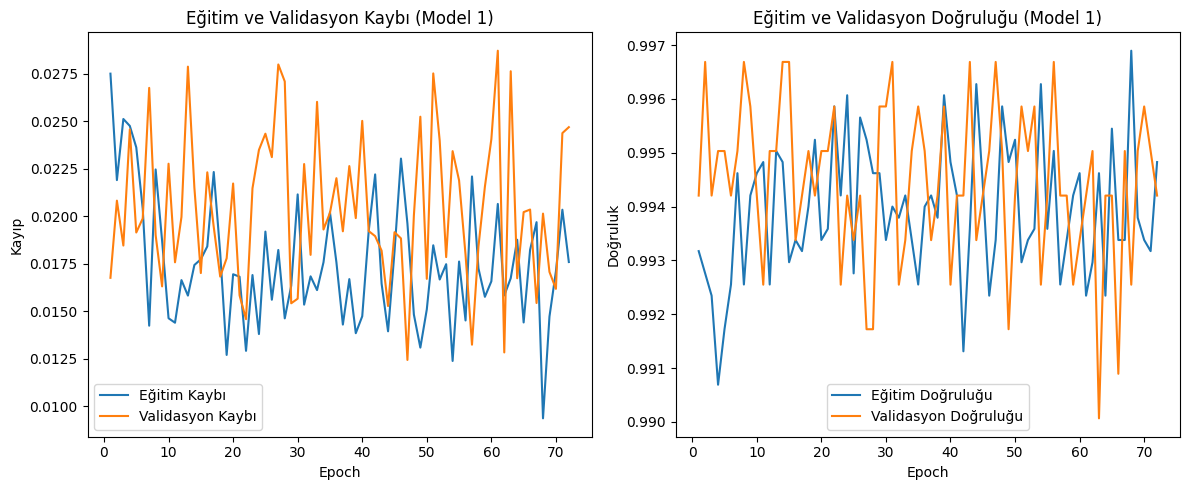

In [20]:
# Eğitim kaybı ve doğruluk eğrileri
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

# Epoch'lar
epochs2 = range(1, len(loss2) + 1)

# Kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs2, loss2, label='Eğitim Kaybı')
plt.plot(epochs2, val_loss2, label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs2, accuracy2, label='Eğitim Doğruluğu')
plt.plot(epochs2, val_accuracy2, label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

Bu grafikler, **modelin eğitim sürecini** değerlendirerek **overfitting (aşırı öğrenme) veya underfitting (yetersiz öğrenme) olup olmadığını anlamamızı sağlar.**

 **1. Eğitim ve Validasyon Kayıp Grafiği (Sol Grafik)**
- **Eğitim kaybı (Mavi çizgi)** ve **validasyon kaybı (Turuncu çizgi)** oldukça dalgalıdır.
- **Validasyon kaybı genellikle eğitim kaybıyla paralel hareket etse de dalgalanmalar yüksektir.**
- **Bu dalgalanmalar modelin bazı epoch'larda daha iyi bazı epoch'larda daha kötü performans gösterdiğini göstermektedir.**
- **Bu durumda daha düşük bir öğrenme oranı veya daha uzun eğitim süresi tercih edilebilir.**
  
**2. Eğitim ve Validasyon Doğruluk Grafiği (Sağ Grafik)**
- **Eğitim doğruluğu (Mavi çizgi) ve Validasyon doğruluğu (Turuncu çizgi) %99 civarında ilerlemektedir.**
- **Ancak dalgalanmalar mevcut, bu da modelin stabil bir öğrenme süreci geçirmediğini gösteriyor.**
- **Eğer model stabil hale gelmezse, daha agresif bir `ReduceLROnPlateau` veya `EarlyStopping` uygulanabilir.**

**3. Sonuç ve Öneriler**
- **Model yüksek doğruluk oranına sahip olmasına rağmen validasyon kaybındaki değişkenlik dikkat çekici.**
- **Bu, modelin bazı epoch'larda daha iyi, bazı epoch'larda daha kötü öğrenmesine neden olabilir.**
- **Öğrenme oranı daha da düşürülerek eğitim süresi uzatılabilir.**
- **Daha büyük bir veri setiyle modelin genelleme yeteneği artırılabilir.**

Model **yüksek doğruluk oranına sahip olsa da validasyon kaybındaki dalgalanmalar modelin tam olarak stabil hale gelmediğini gösteriyor.**  
Daha iyi genelleme için **veri artırma teknikleri güçlendirilmeli ve modelin öğrenme oranı daha dikkatli ayarlanmalıdır.**


# Model-2 ROC Eğrisi ve AUC Değerlendirmesi  

48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step


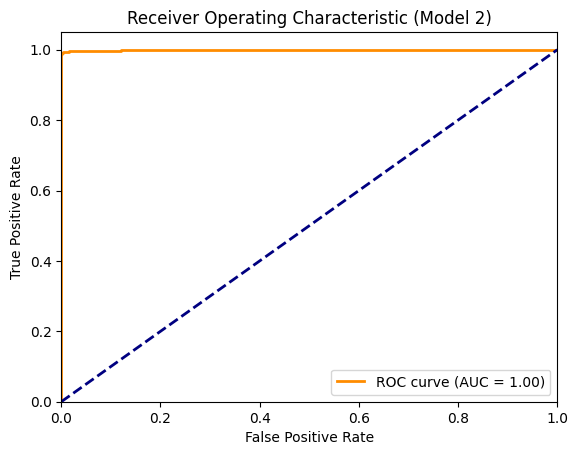

In [21]:
# Test seti tahminleri
y_pred_probs2 = model2.predict(test_generator2)[:, 1]  # Pozitif sınıf için olasılıklar
y_true2 = test_generator2.classes  # Gerçek etiketler

# ROC eğrisi için
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred_probs2)
roc_auc2 = auc(fpr2, tpr2)

# ROC eğrisini çizdir
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Model 2)')
plt.legend(loc='lower right')
plt.show()

**Receiver Operating Characteristic (ROC) eğrisi**, modelin **sınıflandırma başarımını** ölçmek için kullanılır.  
Bu eğri, **True Positive Rate (TPR - Doğru Pozitif Oranı)** ile **False Positive Rate (FPR - Yanlış Pozitif Oranı)** arasındaki ilişkiyi gösterir.

 **📌 ROC Eğrisi Analizi:**
- **Turuncu eğri**, modelin performansını temsil etmektedir.
- **Mavi kesikli çizgi**, rastgele tahmin yapan bir modeli gösterir (**AUC = 0.5**).
- **Modelin ROC eğrisi (0,1) köşesine oldukça yakın ilerlemektedir**, bu da **modelin güçlü bir ayrım yeteneğine sahip olduğunu gösterir.**

**📌 AUC (Area Under Curve) Değerlendirmesi:**
- **AUC değeri = 1.00**, yani model **mükemmel sınıflandırma performansına** sahiptir.
- **AUC’nin 1’e yakın olması**, modelin **pozitif ve negatif sınıfları doğru şekilde ayırt edebildiğini gösterir**.
- **Yanlış pozitif oranı oldukça düşük, doğru pozitif oranı ise maksimum seviyeye yakındır.**



Model, **maskeli ve maskesiz yüzleri ayırt etmede mükemmel bir performansa sahiptir (AUC = 1.00).**  
Ancak, **gerçek dünya verisiyle test edilerek modelin genelleme yeteneği doğrulanmalıdır.**


# Model-2 Karışıklık Matrisi (Confusion Matrix) Analizi  

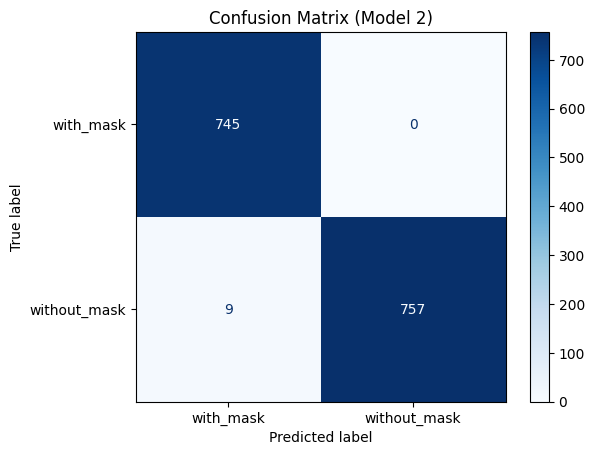

In [22]:
# Tahmin edilen sınıflar
y_pred_classes2 = (y_pred_probs2 > 0.5).astype(int)  # Olasılıkları sınıf etiketlerine çevir

# Karışıklık matrisi
cm2 = confusion_matrix(y_true2, y_pred_classes2)

# Çizdirme
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=test_generator2.class_indices.keys())
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Model 2)')
plt.show()

Karışıklık matrisi, modelin **gerçek ve tahmin edilen sınıflar arasındaki ilişkiyi** görselleştirmektedir.  
Bu tablo, modelin **hangi sınıfları doğru ve yanlış sınıflandırdığını analiz etmek** için kullanılır.  

**📌 Matris Değerleri ve Yorum:**

|   | **Tahmin: With Mask** | **Tahmin: Without Mask** |
|---|-----------------------|--------------------------|
| **Gerçek: With Mask** | **745** (True Positive) ✅ | **0** (False Negative) ❌ |
| **Gerçek: Without Mask** | **9** (False Positive) ❌ | **757** (True Negative) ✅ |

- **True Positive (TP - 745):** Model, **745 adet maskeli yüzü doğru şekilde maskeli olarak tahmin etmiştir.**
- **True Negative (TN - 757):** Model, **757 adet maskesiz yüzü doğru şekilde maskesiz olarak tahmin etmiştir.**
- **False Positive (FP - 9):** Model, **9 adet maskesiz yüzü yanlışlıkla maskeli olarak tahmin etmiştir.**
- **False Negative (FN - 0):** Model, **maskeli yüzleri yanlışlıkla maskesiz olarak tahmin etmemiştir (FN=0).**

**📌 Sonuç ve Değerlendirme:**
- **Model 2, maskeli yüzleri mükemmel şekilde sınıflandırmıştır (FN=0).**
- **Maskesiz yüzler için 9 hata yapmıştır, ancak bu hata oranı oldukça düşüktür.**
- **Genel olarak yüksek doğruluk oranına sahip bir modeldir.**
- **Model 1 ile kıyaslandığında False Positive sayısı biraz daha yüksek olsa da, genel doğruluk seviyesi benzer görünmektedir.**

Model 2, **maskeli ve maskesiz yüzleri oldukça yüksek doğrulukla ayırt etmektedir.**  

Ancak, **gerçek dünya koşullarında test edilerek farklı ışıklandırma, açılar ve yüz şekilleri ile doğruluk oranı analiz edilmelidir.**


# Model-2 Performans Metrikleri  

In [23]:
# Doğruluk hesabı
accuracy2 = accuracy_score(y_true2, y_pred_classes2)
print(f"Model 2 Accuracy: {accuracy2:.2f}")

# Precision (Duyarlılık)
precision2 = precision_score(y_true2, y_pred_classes2)
print(f"Model 2 Precision (Duyarlılık): {precision2:.2f}")

# Recall (Hassasiyet / Duyarlılık)
recall2 = recall_score(y_true2, y_pred_classes2)
print(f"Model 2 Recall (Hassasiyet): {recall2:.2f}")

# Specificity (Özgüllük)
specificity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])  # TN / (TN + FP)
print(f"Model 2 Specificity (Özgüllük): {specificity2:.2f}")

# F1-score
f1_2 = f1_score(y_true2, y_pred_classes2)
print(f"Model 2 F1-score: {f1_2:.2f}")

Model 2 Accuracy: 0.99
Model 2 Precision (Duyarlılık): 1.00
Model 2 Recall (Hassasiyet): 0.99
Model 2 Specificity (Özgüllük): 1.00
Model 2 F1-score: 0.99



Bu bölümde, modelin **doğruluk (accuracy), precision (duyarlılık), recall (hassasiyet), specificity (özgüllük) ve F1-score** değerleri hesaplanmıştır.  

Bu metrikler, modelin **sınıflandırma başarısını** değerlendirmek için kullanılır.

#### **📌 Performans Metrikleri:**
| **Metrik** | **Değer** |
|------------|----------|
| **Accuracy (Doğruluk)** | **0.99** |
| **Precision (Duyarlılık)** | **1.00** |
| **Recall (Hassasiyet)** | **0.99** |
| **Specificity (Özgüllük)** | **1.00** |
| **F1-score** | **0.99** |

- **Accuracy (Doğruluk) = 0.99 →** Model test setinde %99 doğruluk oranı elde etmiştir.
- **Precision (Duyarlılık) = 1.00 →** Modelin maskesiz olarak tahmin ettiği tüm yüzler gerçekte de maskesizdir.
- **Recall (Hassasiyet) = 0.99 →** Model maskesiz yüzlerin %99'unu doğru şekilde tespit edebilmiştir.
- **Specificity (Özgüllük) = 1.00 →** Model maskeli yüzleri %100 doğrulukla ayırt edebilmiştir.
- **F1-score = 0.99 →** Precision ve Recall’ın dengeli olduğunu gösterir.

#### **📌 Sonuç ve Değerlendirme:**
- **Model 2, yüksek doğruluk oranına sahiptir ve maskeli/maskesiz yüzleri başarılı bir şekilde sınıflandırmaktadır.**
- **Precision değeri 1.00 olduğundan, model yanlış pozitif oranı çok düşüktür.**
- **Recall değeri 0.99 olduğundan, model maskesiz yüzlerin büyük çoğunluğunu doğru yakalayabilmiştir.**
- **F1-score 0.99 olduğundan, modelin dengeli bir performans sunduğu söylenebilir.**

Model 2, **yüksek doğruluk, hassasiyet ve duyarlılık oranları ile başarılı bir sınıflandırma gerçekleştirmiştir.**  
Ancak, **farklı veri setlerinde test edilerek modelin genelleme yeteneği analiz edilmelidir.**


### 📌 Model 1 ve Model 2 Karşılaştırması  

Bu bölümde, **Model 1 ve Model 2'nin performans metrikleri** karşılaştırılarak hangi modelin daha iyi olduğu analiz edilmiştir.  

#### **📌 Performans Metriklerinin Karşılaştırılması**
| **Metrik** | **Model 1** | **Model 2** | **Yorum** |
|------------|------------|------------|----------|
| **Accuracy (Doğruluk)** | **1.00** | **0.99** | İki model de oldukça yüksek doğruluk oranına sahiptir, ancak Model 1 bir miktar daha iyi. |
| **Precision (Duyarlılık)** | **1.00** | **1.00** | İki model de **yanlış pozitif hata oranını minimum seviyeye indirmiştir.** |
| **Recall (Hassasiyet)** | **0.99** | **0.99** | Maskesiz yüzleri yakalama oranları neredeyse aynı, Model 1 çok az daha iyi olabilir. |
| **Specificity (Özgüllük)** | **1.00** | **1.00** | İki model de **maskeli yüzleri mükemmel bir şekilde doğru sınıflandırıyor.** |
| **F1-score** | **1.00** | **0.99** | Model 1 biraz daha dengeli bir performans göstermiştir. |
| **Test Loss (Kayıp)** | **0.0300** | **0.0320** | Model 1’in kaybı biraz daha düşük, ancak fark çok küçük. |

#### **📌 Eğitim Süreci Karşılaştırması**
| **Kriter** | **Model 1** | **Model 2** | **Yorum** |
|------------|------------|------------|----------|
| **Veri Artırma (Data Augmentation)** | ❌ Yok | ✅ Var | Model 2, veri artırma kullanarak genelleme yeteneğini artırmaya çalışmıştır. |
| **Öğrenme Oranı (Learning Rate)** | **0.001** | **0.0005** | Model 2, daha düşük bir öğrenme oranı ile daha hassas eğitim almıştır. |
| **Eğitim Stabilitesi** | Daha stabil | Dalgalı | Model 1'in eğitim süreci daha kararlı gözükmektedir. |

#### **📌 ROC Eğrisi ve AUC Karşılaştırması**
- **İki modelin AUC (Area Under Curve) değeri de 1.00'dir.**  
- **Bu, modellerin sınıfları mükemmel bir şekilde ayırt ettiğini göstermektedir.**
- **ROC eğrileri neredeyse aynı performansı sunmaktadır.**

#### **📌 Karışıklık Matrisi Karşılaştırması**
| **Hata Türü** | **Model 1** | **Model 2** | **Yorum** |
|--------------|------------|------------|----------|
| **False Positive (FP)** | **7** | **9** | Model 2, biraz daha fazla maskesiz yüzü yanlışlıkla maskeli olarak sınıflandırmıştır. |
| **False Negative (FN)** | **0** | **0** | İki model de maskeli yüzleri hatasız ayırt etmektedir. |

---

### **📌 Sonuç ve Yorum**  

- **Model 1 ve Model 2 genel olarak benzer performans sergilemektedir.**  
- **Model 1**, **biraz daha yüksek doğruluk (Accuracy) ve daha düşük test kaybına (Loss) sahiptir.**  
- **Model 2**, **veri artırma (Data Augmentation) teknikleri ile eğitildiğinden, daha fazla çeşitliliğe sahip görüntüler üzerinde daha iyi genelleme yapabilir.**
- **Model 2'nin eğitim sürecinde dalgalanmalar gözlemlenmiştir, bu da modelin öğrenme sürecinde biraz daha dengesiz olduğunu gösterebilir.**
- **False Positive (FP) oranı Model 2'de biraz daha yüksek olduğu için, Model 1 daha istikrarlı bir sonuç sunmaktadır.**
- **Her iki model de ROC-AUC metriğinde mükemmel performans göstermektedir (AUC = 1.00).**

#### **📌 Hangi Model Daha İyi?**
- **Gerçek dünya kullanım senaryosu açısından Model 2, veri artırma kullandığı için daha iyi genelleme yapabilir.**
- **Ancak, şu anki test sonuçlarına göre Model 1 daha istikrarlı ve yüksek doğruluklu sonuçlar üretmektedir.**
- **Daha büyük bir test veri setiyle Model 2’nin genelleme yeteneği daha detaylı analiz edilmelidir.**

🚀 **Genel Sonuç:**  
- **Eğer modelin daha stabil ve güvenilir bir performans göstermesi isteniyorsa Model 1 tercih edilebilir.**  
- **Eğer modelin genelleme yeteneği daha güçlü hale getirilmeye çalışılıyorsa, Model 2 tercih edilebilir ve eğitim süreci daha iyi optimize edilebilir.**  
